In [1]:
# Import Needed Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Enable tqdm for pandas apply if needed later
tqdm.pandas()


In [9]:
# drop index columns
index_cols = ['Report ID', 'Report Version']

In [10]:
# Read UK raw data for labelling the cols
UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')
# Read US scaled data
US_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_raw_data.csv')

US_data = US_data.drop(columns=index_cols)
UK_data = UK_data.drop(columns=index_cols)


# Print shape of each DataFrame
print("UK_df_scaled shape:", UK_data.shape)
print("US_df_scaled shape:", US_data.shape)

UK_df_scaled shape: (229782, 21)
US_df_scaled shape: (4159, 21)


/var/folders/0k/whv99z5n5rnb1xp8n07krpcw0000gn/T/ipykernel_7175/2859603240.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  UK_data = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv')


In [11]:
# Read UK scaled data
UK_df_scaled = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded_data.csv')
# Read US scaled data
US_df_scaled = pd.read_csv('/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_encoded_data.csv')
US_df_scaled = US_df_scaled.drop(columns=index_cols)
UK_df_scaled = UK_df_scaled.drop(columns=index_cols)
# Print shape of each DataFrame
print("UK_df_scaled shape:", UK_df_scaled.shape)
print("US_df_scaled shape:", US_df_scaled.shape)

UK_df_scaled shape: (229782, 21)
US_df_scaled shape: (4159, 21)


**Sampling Methods for Clustering**

US


KMeans Clustering Progress: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


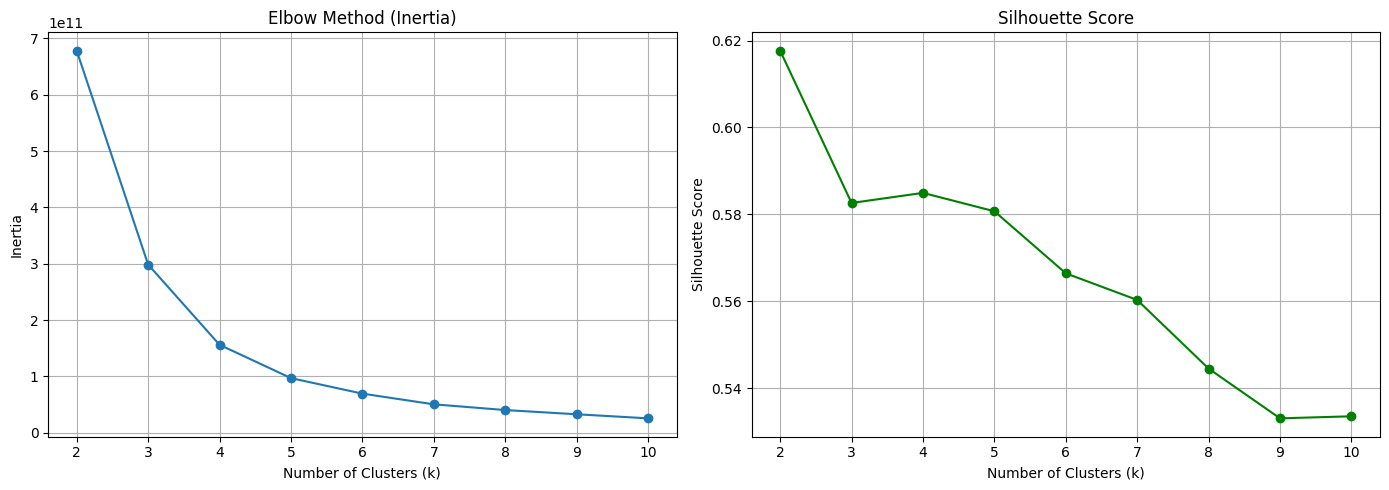

US


KMeans Clustering Progress: 100%|██████████| 9/9 [00:49<00:00,  5.49s/it]


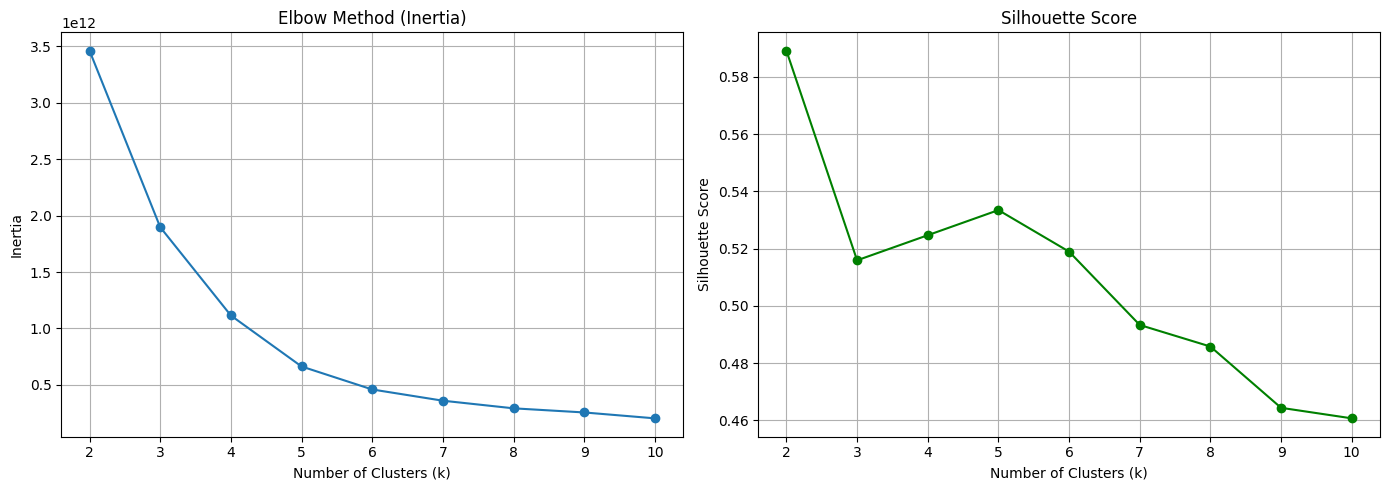

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_kmeans_elbow_silhouette(data, max_k=10):
    inertias = []
    silhouettes = []
    Ks = range(2, max_k + 1)

    for k in tqdm(Ks, desc="KMeans Clustering Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=1)  # n_init=1 for speed
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(data, labels))

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(Ks, inertias, marker='o')
    ax[0].set_title('Elbow Method (Inertia)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('Inertia')
    ax[0].grid(True)

    ax[1].plot(Ks, silhouettes, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Try on smaller subset first
print("US")
plot_kmeans_elbow_silhouette(US_df_scaled, max_k=10)
print("UK")
subset_UK = UK_df_scaled.sample(30000, random_state=42) # had to sample as 30000< taking way too long
plot_kmeans_elbow_silhouette(subset_UK, max_k=10)



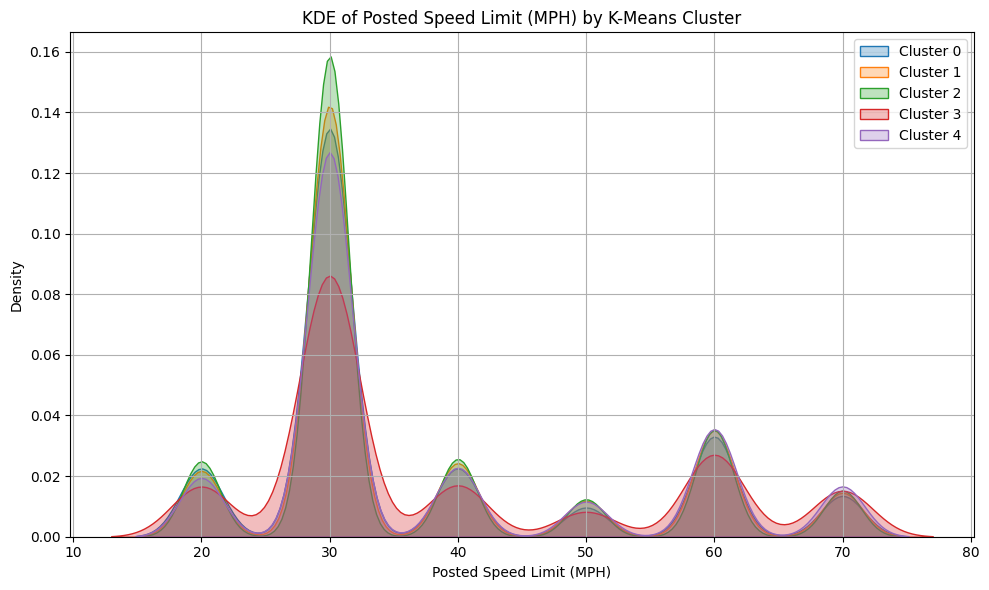

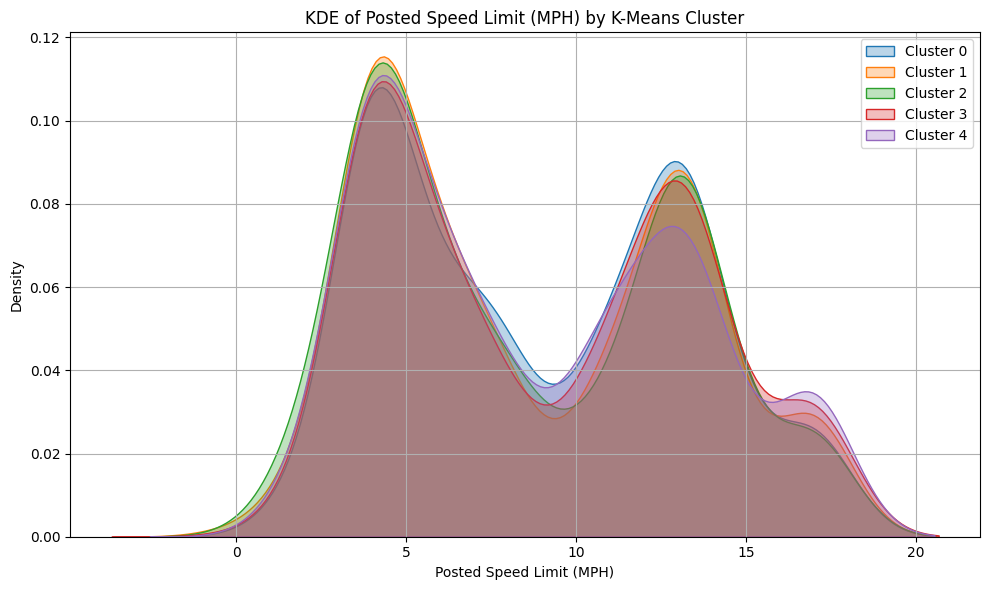

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def kmeans_cluster_speed_kde(scaled_df, original_df, n_clusters=3, speed_col='Posted Speed Limit (MPH)'):
    """
    Performs KMeans clustering on scaled data and plots KDEs of the posted speed limit per cluster.

    Parameters:
    - scaled_df: DataFrame that has been scaled (e.g., with StandardScaler).
    - original_df: Original, unscaled DataFrame with speed_col column.
    - n_clusters: Number of KMeans clusters.
    - speed_col: Name of the speed column in original_df.

    Returns:
    - original_df with a new 'cluster' column.
    """

    # Step 1: Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)

    # Step 2: Add cluster labels to original DataFrame
    original_df = original_df.copy()
    original_df['cluster'] = cluster_labels

    # Step 3: KDE Plot of Posted Speed Limit by Cluster
    plt.figure(figsize=(10, 6))
    for cluster_id in range(n_clusters):
        subset = original_df[original_df['cluster'] == cluster_id]
        sns.kdeplot(subset[speed_col], label=f'Cluster {cluster_id}', fill=True, alpha=0.3)

    plt.title(f'KDE of {speed_col} by K-Means Cluster')
    plt.xlabel(speed_col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return original_df

# Example usage:
UK_df_with_clusters = kmeans_cluster_speed_kde(UK_df_scaled, UK_data, n_clusters=5, speed_col='Posted Speed Limit (MPH)')
US_df_with_clusters = kmeans_cluster_speed_kde(US_df_scaled, US_data.dropna(), n_clusters=5, speed_col='Posted Speed Limit (MPH)')

**PCA plot to see if any clusters**

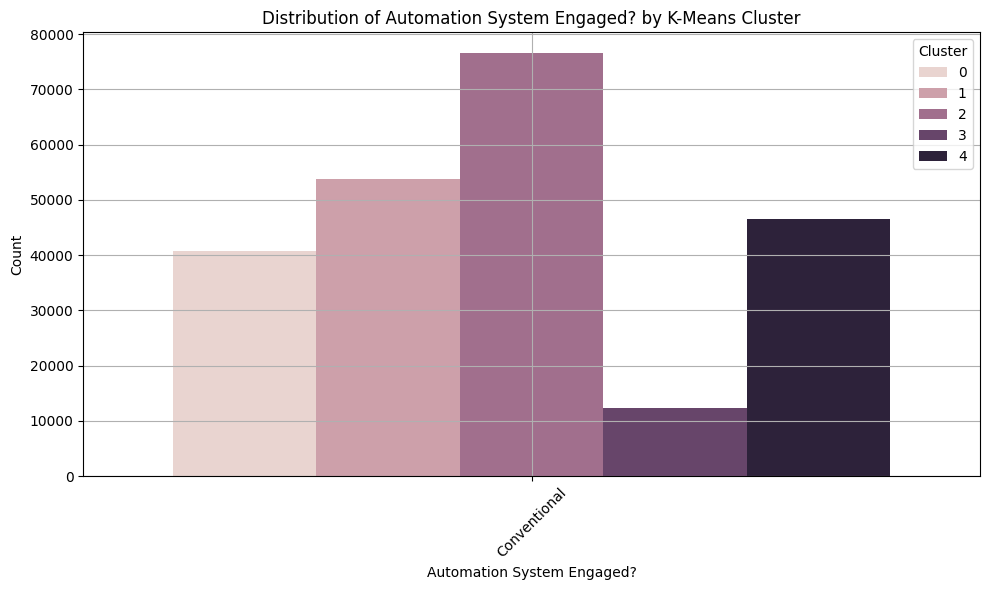

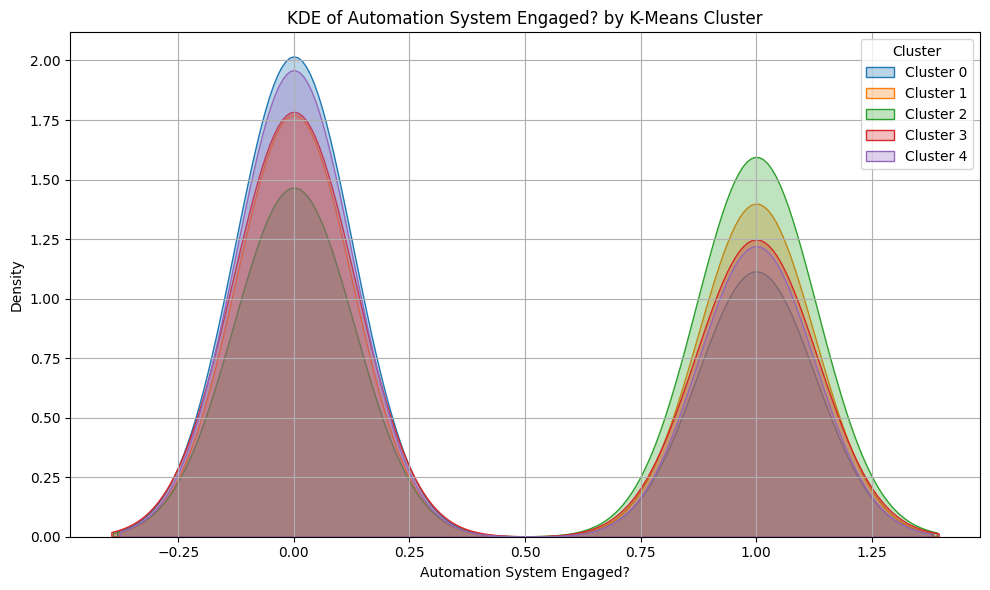

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def kmeans_cluster_plot(scaled_df, original_df, n_clusters=3, plot_col=None):
    """
    Performs KMeans clustering on scaled data and plots KDE (for numeric columns) or
    countplot (for categorical columns) of the specified column per cluster.

    Parameters:
    - scaled_df: DataFrame that has been scaled (e.g., with StandardScaler).
    - original_df: Original, unscaled DataFrame with plot_col column.
    - n_clusters: Number of KMeans clusters.
    - plot_col: Name of the column in original_df to plot.

    Returns:
    - original_df with a new 'cluster' column.
    """

    # Step 1: Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)

    # Step 2: Add cluster labels to original DataFrame
    original_df = original_df.copy()
    original_df['cluster'] = cluster_labels

    # Step 3: Plotting depending on column type
    if plot_col is None or plot_col not in original_df.columns:
        print(f"Column '{plot_col}' not found or not specified. No plot will be generated.")
        return original_df

    plt.figure(figsize=(10, 6))

    if pd.api.types.is_numeric_dtype(original_df[plot_col]):
        # Numeric column -> KDE plot
        for cluster_id in range(n_clusters):
            subset = original_df[original_df['cluster'] == cluster_id]
            sns.kdeplot(subset[plot_col], label=f'Cluster {cluster_id}', fill=True, alpha=0.3)
        plt.title(f'KDE of {plot_col} by K-Means Cluster')
        plt.xlabel(plot_col)
        plt.ylabel('Density')

    else:
        # Categorical column -> Countplot (bar plot)
        sns.countplot(data=original_df, x=plot_col, hue='cluster')
        plt.title(f'Distribution of {plot_col} by K-Means Cluster')
        plt.xlabel(plot_col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)

    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return original_df

UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Automation System Engaged?')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=5, plot_col='Automation System Engaged?')

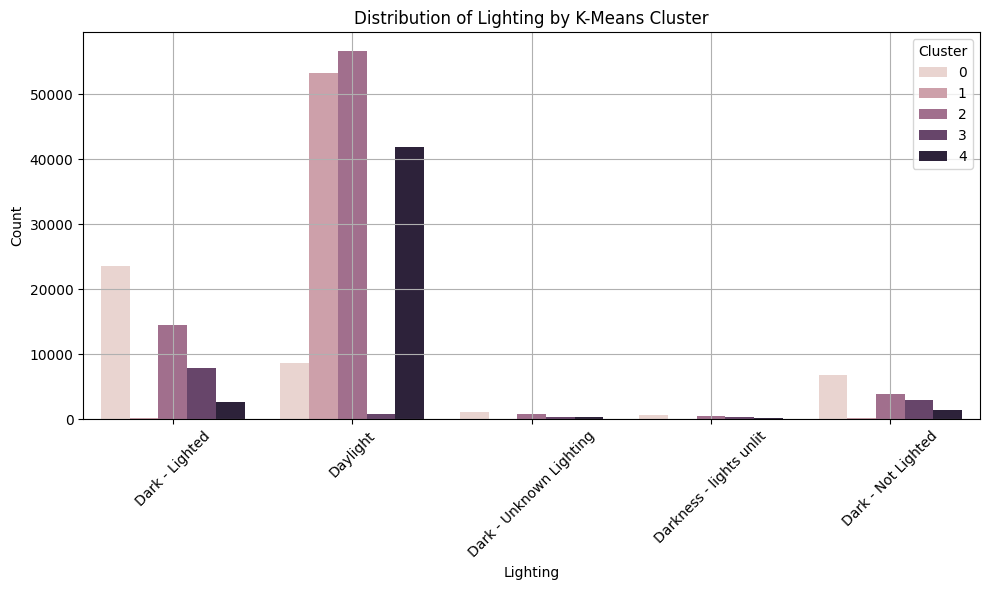

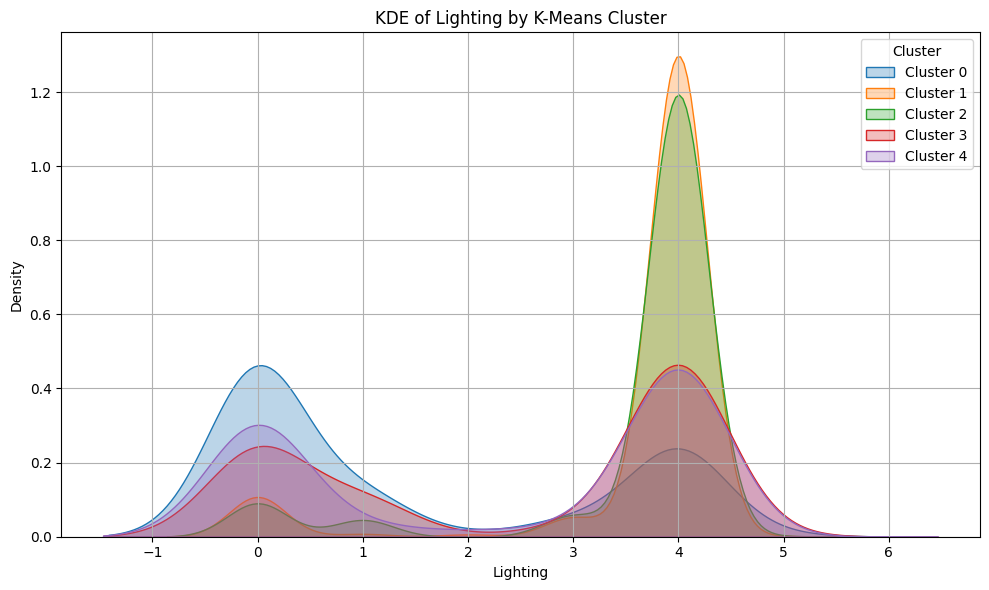

In [17]:
UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Lighting')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=5, plot_col='Lighting')

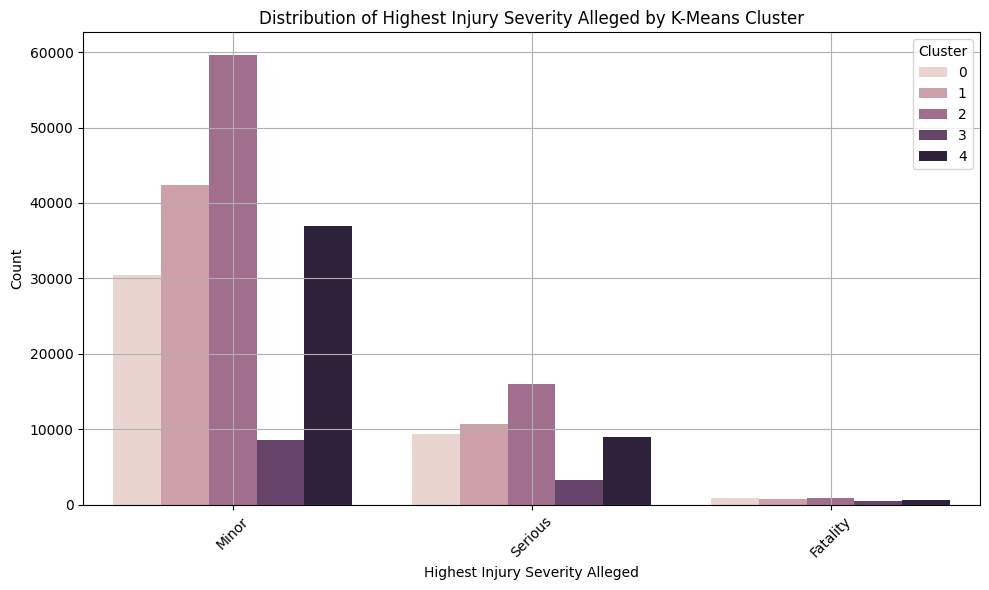

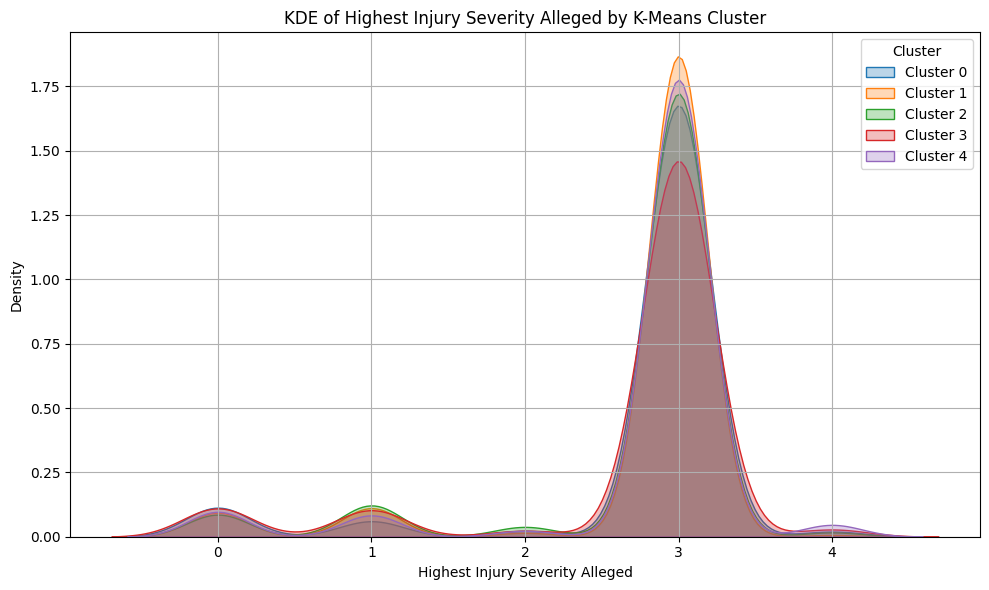

In [18]:
UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Highest Injury Severity Alleged')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=5, plot_col='Highest Injury Severity Alleged')

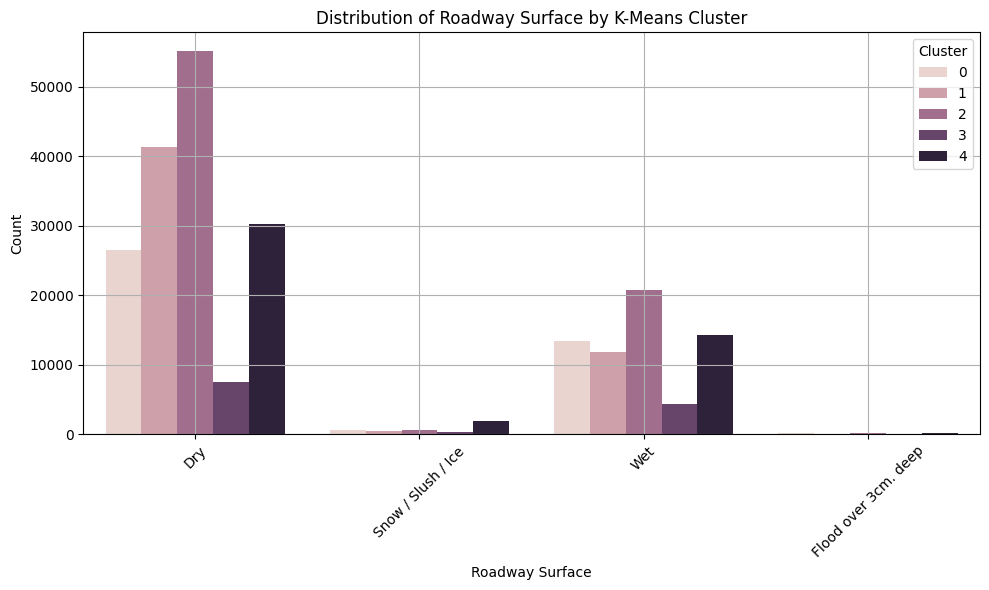

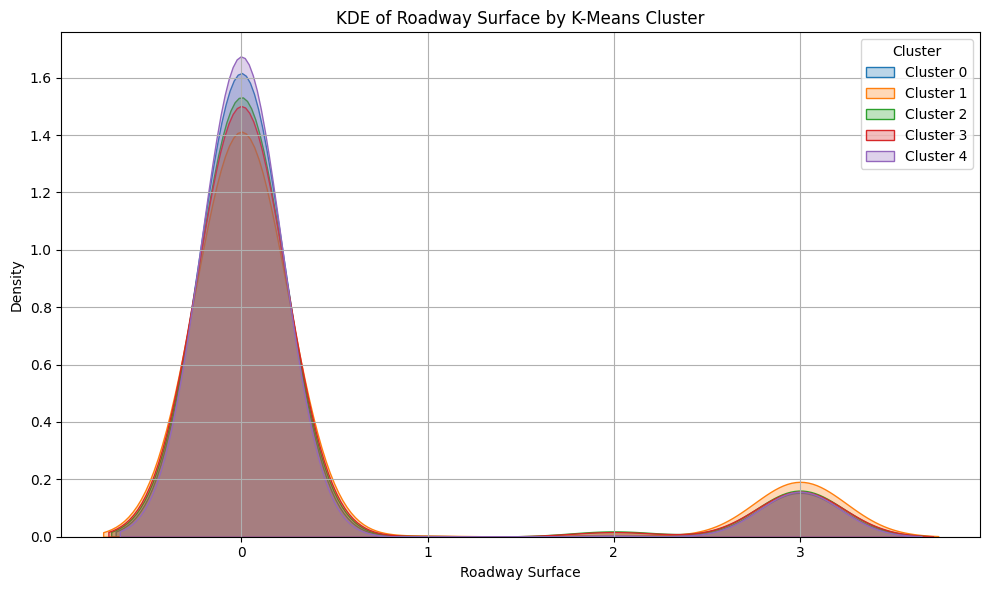

In [19]:
UK_age_clusters = kmeans_cluster_plot(UK_df_scaled, UK_data, n_clusters=5, plot_col='Roadway Surface')
US_age_clusters = kmeans_cluster_plot(US_df_scaled, US_data, n_clusters=5, plot_col='Roadway Surface')

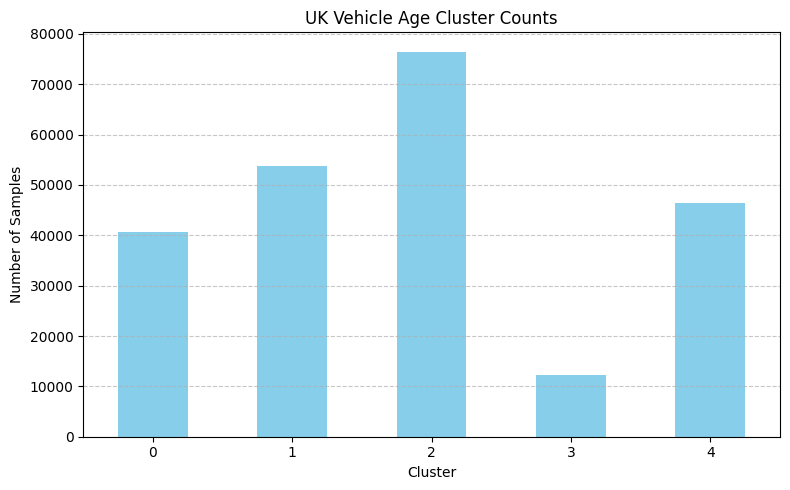

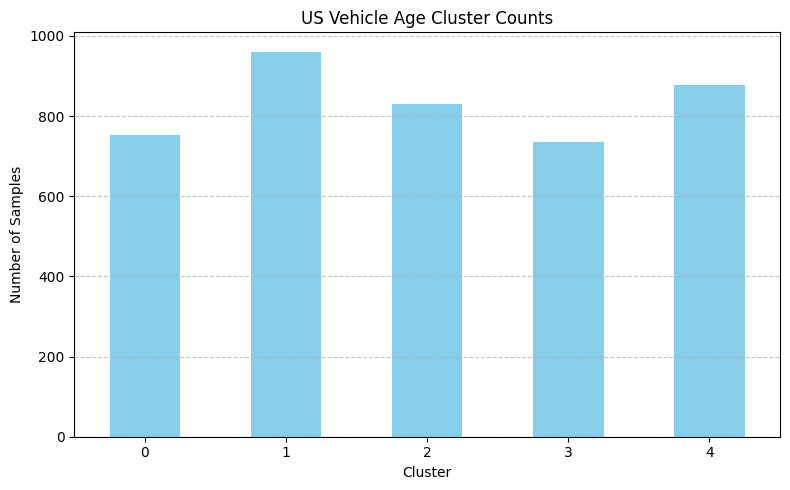

In [20]:
# number of clusters
import matplotlib.pyplot as plt

def plot_cluster_counts(clustered_df, cluster_col='cluster', title='Number of Samples per Cluster'):
    counts = clustered_df[cluster_col].value_counts().sort_index()
    
    plt.figure(figsize=(8, 5))
    counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
# Assuming UK_age_clusters and US_age_clusters are the outputs from your clustering function
plot_cluster_counts(UK_age_clusters, cluster_col='cluster', title='UK Vehicle Age Cluster Counts')
plot_cluster_counts(US_age_clusters, cluster_col='cluster', title='US Vehicle Age Cluster Counts')

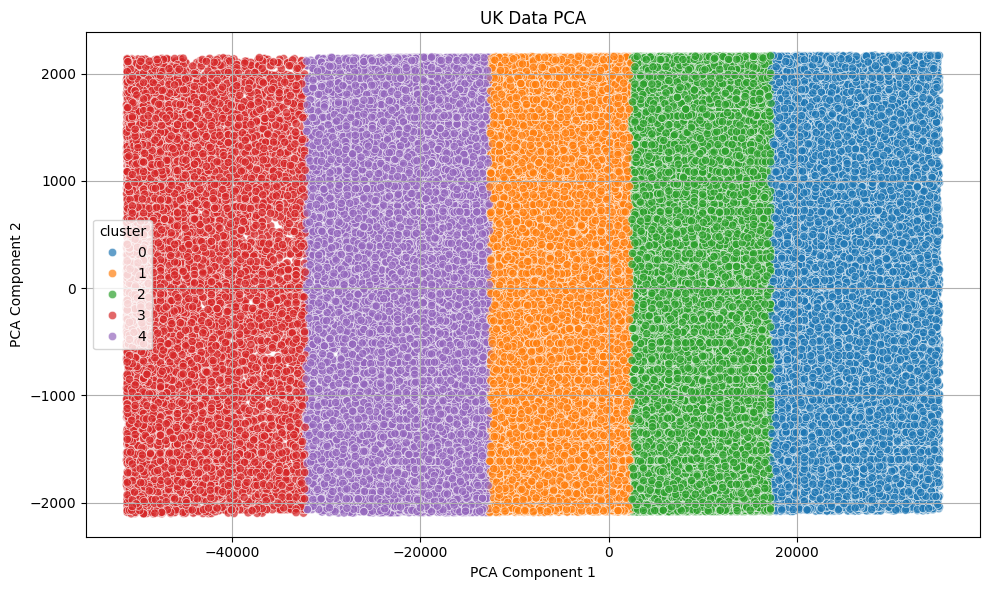


Cluster mode summary for: UK Data PCA
             Make   Model  Model Year ADS Equipped?  \
cluster                                               
0            FORD  FIESTA        2007  Conventional   
1            FORD  FIESTA        2015  Conventional   
2            FORD  FIESTA        2016  Conventional   
3        VAUXHALL  FIESTA        2007  Conventional   
4            FORD  FIESTA        2016  Conventional   

        Automation System Engaged? Incident Date Incident Time (24:00)  \
cluster                                                                  
0                     Conventional    2019-08-16              19:30:00   
1                     Conventional    2021-06-01              14:00:00   
2                     Conventional    2019-06-27              17:00:00   
3                     Conventional    2020-01-01              00:30:00   
4                     Conventional    2020-02-06              08:30:00   

               City    State        Roadway Type  ...  \

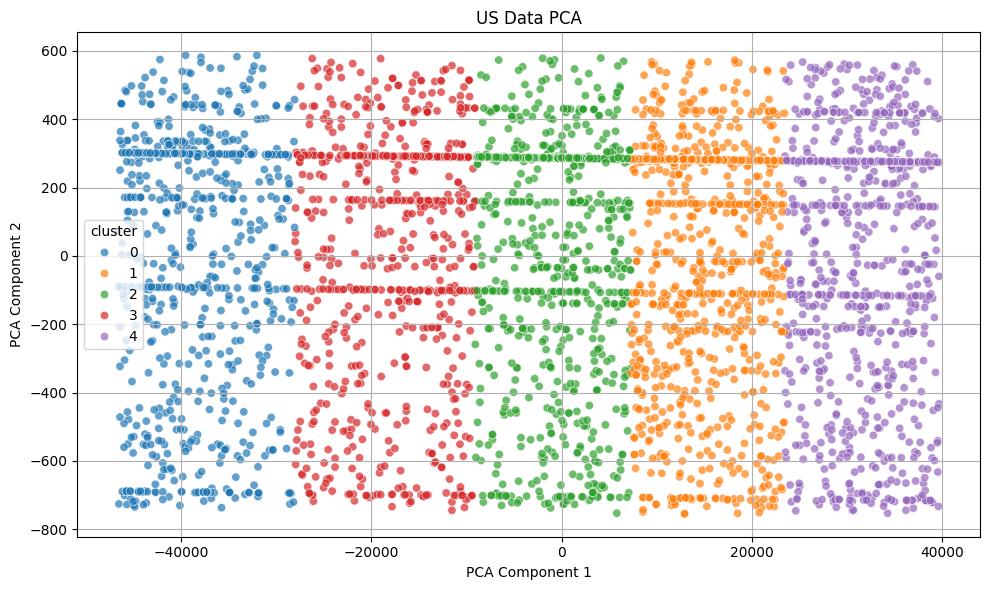


Cluster mode summary for: US Data PCA
         Make  Model  Model Year  ADS Equipped?  Automation System Engaged?  \
cluster                                                                       
0          57    101           9              0                           0   
1          57     73           7              0                           0   
2          57     73           7              1                           1   
3          57     98           7              0                           0   
4          57    101           7              0                           0   

         Incident Time (24:00)  City  State  Roadway Type  Roadway Surface  \
cluster                                                                      
0                          960  1037      3             0                0   
1                        62400  1037      3             0                0   
2                        48240  1037      3             0                0   
3                

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_pca_2d(scaled_df, original_df, title='PCA of Data'):
    """
    Plots the first two PCA components of the scaled data, colored by cluster if present.
    Also prints the mode of each feature grouped by cluster.
    """
    # Apply PCA
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_df)

    # Copy and append PCA results
    pca_df = original_df.copy()
    pca_df['PCA1'] = pca_components[:, 0]
    pca_df['PCA2'] = pca_components[:, 1]

    # Plot
    plt.figure(figsize=(10, 6))
    if 'cluster' in original_df.columns:
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', alpha=0.7)
    else:
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', alpha=0.6)

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Cluster summary using mode
    if 'cluster' in original_df.columns:
        cluster_mode = original_df.groupby('cluster').agg(lambda x: pd.Series.mode(x)[0] if not x.mode().empty else None)
        print(f"\nCluster mode summary for: {title}")
        print(cluster_mode)


# Example usage:
plot_pca_2d(UK_df_scaled, UK_df_with_clusters, title='UK Data PCA')
plot_pca_2d(US_df_scaled, US_df_with_clusters, title='US Data PCA')

Running t-SNE on US data...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4159 samples in 0.001s...
[t-SNE] Computed neighbors for 4159 samples in 0.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4159
[t-SNE] Computed conditional probabilities for sample 2000 / 4159
[t-SNE] Computed conditional probabilities for sample 3000 / 4159
[t-SNE] Computed conditional probabilities for sample 4000 / 4159
[t-SNE] Computed conditional probabilities for sample 4159 / 4159
[t-SNE] Mean sigma: 319.718902
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.124245
[t-SNE] KL divergence after 1000 iterations: 0.414315
Running t-SNE on UK sample...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.001s...
[t-SNE] Computed neighbors for 30000 samples in 0.755s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional pr

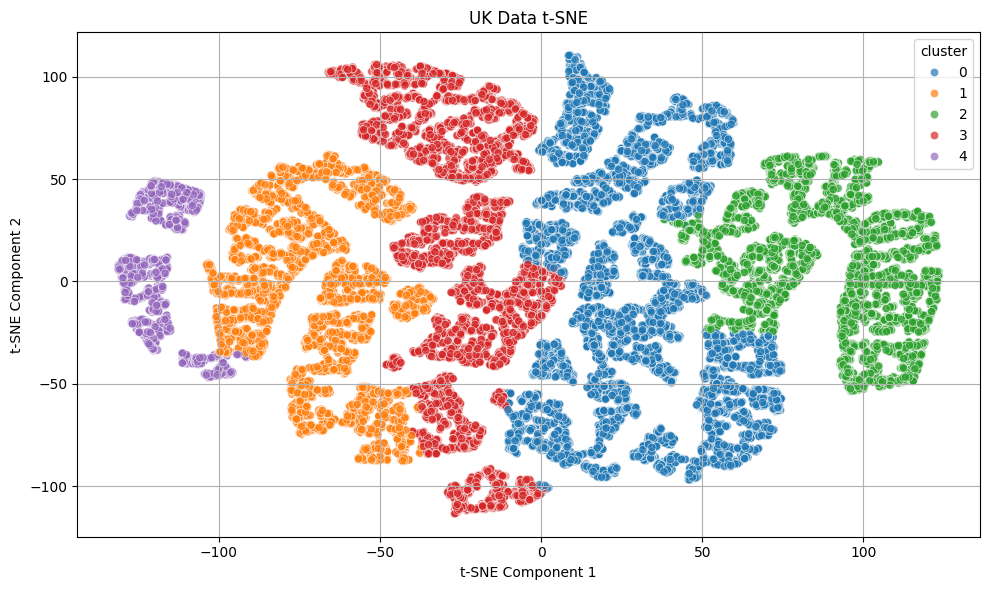

In [25]:
# Load US scaled data

# Apply KMeans clustering
US_clusters = KMeans(n_clusters=5, random_state=42).fit_predict(US_df_scaled)
US_df_with_clusters = US_df_scaled.copy()
US_df_with_clusters['cluster'] = US_clusters
print("Running t-SNE on US data...")
tsne_us = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
tsne_results_us = tsne_us.fit_transform(US_df_scaled)
US_df_with_clusters['tsne_1'] = tsne_results_us[:, 0]
US_df_with_clusters['tsne_2'] = tsne_results_us[:, 1]
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


# Sample 30,000 rows
UK_sampled = UK_df_scaled.sample(n=30000, random_state=42).reset_index(drop=True)

# Apply KMeans clustering on the sample
UK_clusters = KMeans(n_clusters=5, random_state=42).fit_predict(UK_sampled)
UK_sampled['cluster'] = UK_clusters

print("Running t-SNE on UK sample...")
tsne_uk = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
tsne_results_uk = tsne_uk.fit_transform(UK_sampled.drop(columns=['cluster']))  # exclude cluster col

# Add t-SNE results to the sampled DataFrame
UK_sampled['tsne_1'] = tsne_results_uk[:, 0]
UK_sampled['tsne_2'] = tsne_results_uk[:, 1]

# UK_sampled now contains cluster labels and t-SNE components for 30,000 points
print(UK_sampled.head())
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# STEP 2: Sample 30,000 rows
UK_sampled = UK_df_scaled.sample(n=30000, random_state=42).reset_index(drop=True)

# STEP 3: Apply KMeans clustering on the sample
UK_clusters = KMeans(n_clusters=5, random_state=42).fit_predict(UK_sampled)
UK_sampled['cluster'] = UK_clusters

# STEP 4: Apply t-SNE on the sample (excluding cluster column)
print("Running t-SNE on UK data...")
tsne_uk = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
tsne_results_uk = tsne_uk.fit_transform(UK_sampled.drop(columns=['cluster']))

# STEP 5: Add t-SNE components to sampled data
UK_sampled['tsne_1'] = tsne_results_uk[:, 0]
UK_sampled['tsne_2'] = tsne_results_uk[:, 1]

# STEP 6: Plotting function
def plot_tsne_2d(df, title='t-SNE of Data'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='tsne_1', y='tsne_2', hue='cluster', palette='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# STEP 7: Plot UK t-SNE
plot_tsne_2d(UK_sampled, title='UK Data t-SNE')
